In [1]:
import numpy as np
import pandas as pd

import h5py

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import math
import random
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

**Get the enformer output samples from plotting**

In [2]:
enformerOutputFile = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/EnformerOutputs/enformer_output_validation_class_balanced.hdf5"
with h5py.File(enformerOutputFile, 'r') as f:
    samples = f["validationEnformerOutput"][:]
    print(samples.shape)

(202609, 10626)


**Split the Enformer output samples into donors and recipients**

In [3]:
with h5py.File(enformerOutputFile, 'r') as f:
    labels = f["validationLabels"][:]
    recip_indices = np.where(labels == 1)[0]
    donor_indices = np.where(labels == 0)[0]

donors = samples[donor_indices][0:25000]
recips = samples[recip_indices][0:25000]

bin_1_donors = donors[:, 0:5313]
bin_2_donors = donors[:, 5313: 10626]
averaged_donors = bin_1_donors + bin_2_donors

bin_1_recips = recips[:, 0:5313]
bin_2_recips = recips[:, 5313: 10626]
averaged_recips = bin_1_recips + bin_2_recips
print(f"Shape of averaged outputs = {averaged_donors.shape} and {averaged_donors.shape}")

Shape of averaged outputs = (25000, 5313) and (25000, 5313)


In [4]:
#add target_name and target columns in the df to specify the class type 
num_donors = len(averaged_donors)
num_recips = len(averaged_donors)

#Get scaled DF of donors and recipients for plotting. 
combined_samples = np.vstack((averaged_donors, averaged_donors))
num_tracks = combined_samples.shape[1]

columnNames = []
for i in range(1, num_tracks+1):
    columnNames.append("EnformerTrack" + str(i))

donor_recip_enformer_tracks_df = pd.DataFrame(combined_samples, columns = columnNames)
donor_recip_enformer_tracks_df_scaled = StandardScaler().fit_transform(donor_recip_enformer_tracks_df)

enformer_tracks_scaled_df = pd.DataFrame(donor_recip_enformer_tracks_df_scaled, columns = columnNames)

enformer_tracks_scaled_df.loc[0:num_donors-1, "target"] = 1
enformer_tracks_scaled_df.loc[0:num_donors-1, "target_name"] = "donor"
enformer_tracks_scaled_df.loc[num_donors:num_donors + num_recips - 1, "target"] = 0
enformer_tracks_scaled_df.loc[num_donors:num_donors + num_recips -1, "target_name"] = "recipient"
print(enformer_tracks_scaled_df.shape)

(50000, 5315)


**Get the PCA data for plotting - numbers for each of the PC aces etc**

In [5]:
"""
all_donor_samples and all_recip_samples are 2D numpy arrays. 
Given all donor and recipient samples (all the donors first and recipients second), it returns a PCA df. The components 
in the PCA df = n_components specified. The method already takes care of adding a column(target_name) in the PCA df specifying if
the entry is a donor or recipient. 
"""

def getPcaDataForPlotting(n_components, pcaColumnNames, all_donor_samples, all_recip_samples, num_donor_samples = False, num_recip_samples = False, plotPcaExplainedVariance = False):
    num_donor_samples = all_donor_samples.shape[0]
    num_recip_samples = all_recip_samples.shape[0]
    combined_samples = np.vstack((all_donor_samples, all_recip_samples))
    num_tracks = combined_samples.shape[1]

    columnNames = []
    for i in range(1, num_tracks+1):
        columnNames.append("EnformerTrack" + str(i))

    donor_recip_enformer_tracks_df = pd.DataFrame(combined_samples, columns = columnNames)
    donor_recip_enformer_tracks_df_scaled = StandardScaler().fit_transform(donor_recip_enformer_tracks_df)

    pca = PCA(n_components)

    #This will create a numpy array with only 3 columns inplace of 10626 columns 
    pca_features = pca.fit_transform(donor_recip_enformer_tracks_df_scaled)

    pca_df = pd.DataFrame(data = pca_features, columns = pcaColumnNames)

    #Set target and target names in the PCA df 
    pca_df.loc[0:num_donor_samples-1, "target"] = 1
    pca_df.loc[0:num_donor_samples-1, "target_name"] = "donor"
    pca_df.loc[num_donor_samples:num_donor_samples + num_recip_samples - 1, "target"] = 0
    pca_df.loc[num_donor_samples:num_donor_samples + num_recip_samples -1, "target_name"] = "recipient"
    return pca, pca_df

**Call functions for getting PCA data for the given Enformer output samples**

In [6]:
#Get 100 PCs for the Enformer tracks data
pca_df_column_names = []
for i in range(1, 101):
    pca_df_column_names.append("PC" + str(i))

pca, pca_df = getPcaDataForPlotting(100, pca_df_column_names, donors, recips, False, False, False)
# pca_df.head(10)

In [14]:
#Get 100 PCs for the Enformer tracks data
pca_df_column_names = []
for i in range(1, 10627):
    pca_df_column_names.append("PC" + str(i))

pca_10626, pca_df_10626 = getPcaDataForPlotting(10626, pca_df_column_names, donors, recips, False, False, False)
# pca_df.head(10)

In [13]:
np.sum(pca_10626.explained_variance_ratio_)

0.9944834

In [7]:
def plotPcaExplainedVarianceBarGraph(pca):
    n_features = range(pca.n_components_)
    plt.bar(n_features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(n_features)

def plotPcaData3D(pca, pca_df, columnNames, plotPcaExplainedVariance):
    if(plotPcaExplainedVariance):
        plotPcaExplainedVarianceBarGraph(pca)

    x = pca_df[columnNames[0]]
    y = pca_df[columnNames[1]]

    col_1_variance = round(pca.explained_variance_ratio_[0], 2)
    col_2_variance = round(pca.explained_variance_ratio_[1], 2)
    col_3_variance = round(pca.explained_variance_ratio_[2], 2)

    fig = plt.figure()

    ax = fig.add_subplot(111, projection = "3d")

    ax.set_xlabel(columnNames[0] + "(" + str(col_1_variance) + ")")
    ax.set_ylabel(columnNames[1] + "(" + str(col_2_variance) + ")")
    ax.set_zlabel(columnNames[2] + "(" + str(col_3_variance) + ")")

    donor_pca = pca_df.loc[pca_df['target_name'] == "donor"]
    z = donor_pca[columnNames[2]]
    x = donor_pca[columnNames[0]]
    y = donor_pca[columnNames[1]]
    
    plt.scatter(x, y, z, color='red')

    recip_pca = pca_df.loc[pca_df['target_name'] == "recipient"]
    z = recip_pca[columnNames[2]]
    x = recip_pca[columnNames[0]]
    y = recip_pca[columnNames[1]]
    
    plt.scatter(x, y, z, color='blue')

    plt.title(f"3D PCA graph of enformer outputs : {len(pca_df)} samples")
    plt.show()

def plotPcaData2d(pca, pca_df, columnNames, plotPcaExplainedVariance):
    if(plotPcaExplainedVariance):
        plotPcaExplainedVarianceBarGraph(pca)

    x = pca_df[columnNames[0]]
    y = pca_df[columnNames[1]]

    col_1_variance = round(pca.explained_variance_ratio_[0], 2)
    col_2_variance = round(pca.explained_variance_ratio_[1], 2)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel(columnNames[0] + " (" + str(col_1_variance) + "%)")
    ax.set_ylabel(columnNames[1] + " (" + str(col_2_variance) + "%)")

    donor_pca = pca_df.loc[pca_df['target_name'] == "donor"]
    x = donor_pca[columnNames[0]]
    y = donor_pca[columnNames[1]]
    
    plt.scatter(x, y, color='red', label='Donor', alpha = 0.3) #Make the points transparent so they don't completely overlap and hide each other 

    recip_pca = pca_df.loc[pca_df['target_name'] == "recipient"]
    x = recip_pca[columnNames[0]]
    y = recip_pca[columnNames[1]]
    
    plt.scatter(x, y, color='blue', label='Recipient', alpha = 0.4)
    plt.legend(loc='best')
    plt.title(f"PCA plot of Enformer tracks")
    plt.show()

def pcaSeabornJointPlot2d(pca, pca_df, columnNames, title = "PCA plot of Enformer tracks"):
        col_1_variance = round(pca.explained_variance_ratio_[0], 2)
        col_2_variance = round(pca.explained_variance_ratio_[1], 2)

        xlabel = columnNames[0] + " (" + str(col_1_variance) + "%)"
        ylabel = columnNames[1] + " (" + str(col_2_variance) + "%)"

        sns.jointplot(data=pca_df, x=columnNames[0], y=columnNames[1], hue="target_name")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='best')
        # plt.title(title, y = 1.2)
        plt.show()

50000


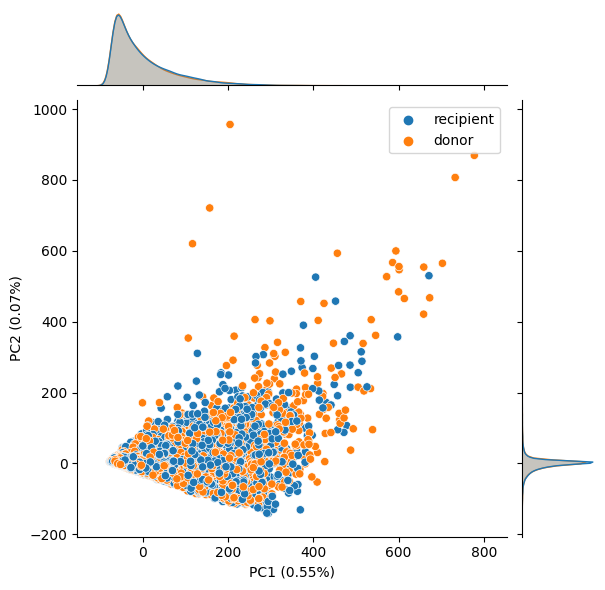

In [20]:
#Seaborn joint distribution plot of 2 most significant PC axes from 100
pc_column_names = ["PC1", "PC2"]
shuffled_pca_df = pca_df.sample(frac=1).reset_index(drop=True)
print(len(shuffled_pca_df))
pcaSeabornJointPlot2d(pca, shuffled_pca_df, pc_column_names)

In [ ]:
#Scatter plot of 2 most significant components out of 100 
pc_column_names = ["PC1", "PC2"]
plotPcaData2d(pca, pca_df, pc_column_names, True)

In [ ]:
#Get only 2 PCs from the Enformer track data and make a seaborn joint distribution plot of those two. 
pca_df_column_names = ["PC1", "PC2"]
pca_2_axes, pca_df_2_axes = getPcaDataForPlotting(2, pca_df_column_names, donors, recips, False, False, False)

print(pca_df_2_axes.head(10))
print(pca_2_axes.explained_variance_ratio_)
pcaSeabornJointPlot2d(pca_2_axes, pca_df_2_axes, pca_df_column_names)

**Get Enformer track indices for a particular cell type and 

**Get Enformer track indices corresponding to the given cell types and the track type**

In [8]:
def getEnformerTrackIndices(track_type, cell_type):
    allowed_cell_types = ["lung", "blood"]
    if(cell_type not in allowed_cell_types):
        print(f"Cell type should be lung or blood")
        return
    
    allowed_track_types = ["CAGE", "DNASE", "CHIP", "ATAC"]
    if(track_type not in allowed_track_types):
        print(f"track type should be one of {allowed_track_types}")
        return

    #Get the indices for tracks from the 5313 tracks have "lung" in the description
    targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
    df = pd.read_csv(targets_txt, sep='\t')

    new_df = pd.DataFrame()

    #Create a new df with only the index column and description col from prev df. Split the df into exp_type and cell_type_desc columns 
    for i in range(0, len(df)):
        description = df["description"][i]
        exp_type = description.split(':', 1)[0]
        cell_type_desc = description.split(':', 1)[1]

        new_df.loc[i, "index"] = df["index"][i]
        new_df.loc[i, "expt_type"] = exp_type
        new_df.loc[i, "cell_type_desc"] = cell_type_desc

    if(cell_type == "lung"):
        indices = new_df.index[new_df['cell_type_desc'].str.contains(cell_type) & new_df["expt_type"].str.contains(track_type)].tolist()
        print(f"Cell type is lung and indices are {indices}")
    else:
        blood_cell_type_search_strings = ["Basophils", "Eosinophils", "monocyte", "T-cell", "erythro", "hematopoietic", "B-cell", "granulocyte"]
        indices = []
        for blood_cell in blood_cell_type_search_strings:
            cell_type_indices = new_df.index[new_df["cell_type_desc"].str.contains(blood_cell) & new_df["expt_type"].str.contains(track_type).tolist()]
            indices.extend(cell_type_indices)

        print(f"Cell type is blood and indices are {indices}")
    
    return indices

**Make a seaborn joint plot of one lung and one blood cell Enformer track for donors and recipients**

In [ ]:
#Plot only one lung DNAse track with one Tcell DNAse track 
lung_dnase_indices = getEnformerTrackIndices("DNASE", "lung")
blood_dnase_indices = getEnformerTrackIndices("DNASE", "blood")

#Get donor samples for indices and dataframes from samples for these indices - With lung and tcell columns
donors = samples[donor_indices]
lung_col_name = f"lung microvascular endothelial cell female DNASE Enformer track"
blood_col_name = f"CD14-positive monocyte female DNASE Enformer track"

donor_lung_dnase = donors[:, lung_dnase_indices[0]]
donor_tcell_dnase = donors[:, blood_dnase_indices[0]]

donor_lung_tcell_df = pd.DataFrame(donor_lung_dnase, columns = [lung_col_name])
donor_lung_tcell_df[blood_col_name] = donor_tcell_dnase
donor_lung_tcell_df["class_type"] = "donor"

#Get recip samples for indices and dataframes from samples for these indices - With lung and tcell columns
recip_lung_dnase = recips[:, lung_dnase_indices[0]]
recip_tcell_dnase = recips[:, blood_dnase_indices[0]]

recip_lung_tcell_df = pd.DataFrame(recip_lung_dnase, columns = [lung_col_name])
recip_lung_tcell_df[blood_col_name] = recip_tcell_dnase
recip_lung_tcell_df["class_type"] = "recipient"

combined_donor_recip_lung_tcell_df = pd.concat([donor_lung_tcell_df, recip_lung_tcell_df])

sns.jointplot(data=combined_donor_recip_lung_tcell_df, x=lung_col_name, y=blood_col_name, hue="class_type")
plt.legend(loc='best')
plt.title(f"Comparison of a DNASE track for lung and blood cell types for donors and recipients", y = 1.2)
plt.show()

**Get Enformer tracks corresponding to all Lung and Blood cell types**

In [9]:
lung_dnase_indices = getEnformerTrackIndices("DNASE", "lung")
blood_dnase_indices = getEnformerTrackIndices("DNASE", "blood")

#Get donor samples for lung and blood indices, combine them
donor_lung_dnase = donors[:, lung_dnase_indices]
donor_blood_dnase = donors[:, blood_dnase_indices]
donor_lung_blood = np.hstack((donor_lung_dnase, donor_blood_dnase))

#Get recipient samples for lung and blood indices, combine them
recip_lung_dnase = recips[:, lung_dnase_indices]
recip_blood_dnase = recips[:, blood_dnase_indices]
recip_lung_blood = np.hstack((recip_lung_dnase, recip_blood_dnase))

Cell type is lung and indices are [105, 106, 111, 138, 167, 200, 229, 231, 245, 272, 279, 295, 314, 327, 387, 388, 390, 396, 400, 406, 407, 409, 419, 437, 461, 464, 487, 492, 512, 569, 579, 589, 590, 591, 603, 627, 632, 645, 649, 655, 659, 668]
Cell type is blood and indices are [41, 131, 392, 508, 517, 188, 351, 366, 488, 489, 214, 233, 346, 369, 410, 454, 588, 598, 634, 61, 211, 214, 233, 333, 346, 369, 410, 454, 588, 598, 634]


**Make a PCA plot of all lung and blood cell type Enformer tracks marked by donors and recipients**

In [ ]:
pca_col_names = ["PC1", "PC2"]

cell_specific_pca, cell_specific_pca_df = getPcaDataForPlotting(2, pca_col_names, donor_lung_blood, recip_lung_blood, False, False, False)
print(cell_specific_pca_df.head(10))

shuffled_cell_specific_pca_df = cell_specific_pca_df.sample(frac=1).reset_index(drop=True)
print(len(shuffled_cell_specific_pca_df))
title = "PCA plot of lung and blood cell type specific Enformer tracks"
pcaSeabornJointPlot2d(cell_specific_pca, shuffled_cell_specific_pca_df, pca_col_names, title)

**Methods to get df from donor, recipient samples(after balancing class) and to get Logistic regression predictions**

In [10]:
def getDfForLogRegFromDonorAndRecips(all_donor_samples, all_recip_samples):
    num_donor_samples = all_donor_samples.shape[0]
    num_recip_samples = all_recip_samples.shape[0]

    min_sample_count = min(num_donor_samples, num_recip_samples)
    donor_indices_to_pick = random.sample(range(0, num_donor_samples), min_sample_count)
    recip_indices_to_pick = random.sample(range(0, num_recip_samples), min_sample_count)

    all_donor_samples = all_donor_samples[donor_indices_to_pick]
    all_recip_samples = all_recip_samples[recip_indices_to_pick]
    print(f"All samples shape donor: {all_donor_samples.shape} and recipient: {all_recip_samples.shape}")
    combined_samples = np.vstack((all_donor_samples, all_recip_samples))
    print(f"Combined samples shape: {combined_samples.shape}")
    num_tracks = combined_samples.shape[1]

    columnNames = []
    for i in range(1, num_tracks+1):
        columnNames.append("EnformerTrack" + str(i))

    donor_recip_df = pd.DataFrame(combined_samples, columns = columnNames)

    #Set target and target names in the PCA df 
    donor_recip_df.loc[0:min_sample_count-1, "target"] = 1
    donor_recip_df.loc[0:min_sample_count-1, "target_name"] = "donor"
    donor_recip_df.loc[min_sample_count:2*min_sample_count - 1, "target"] = 0
    donor_recip_df.loc[min_sample_count:2*min_sample_count -1, "target_name"] = "recipient"

    return donor_recip_df

def getLogisticRegressionPredictions(features_df, labels):
    x_train, x_test, y_train, y_test = train_test_split(features_df, labels, test_size = 0.3, random_state = 0, shuffle=True)
    print(x_train.shape, x_test.shape, len(y_train), len(y_test))

    #The data from all different Enformer tracks could have different scales. Scale, so the model can converge faster
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.fit_transform(x_test)

    #Train logistic regression model and get predictions
    logreg = LogisticRegression(random_state=16, solver='lbfgs', max_iter=1000)
    logreg.fit(x_train_scaled, y_train)
    y_pred_train = logreg.predict(x_train_scaled)
    y_pred_test = logreg.predict(x_test_scaled)
    y_pred_prob = logreg.predict_proba(x_test_scaled)[::,1]

    print(f"Training: True positives: {y_train.count(1)},True negatives: {y_train.count(0)}")
    print(f"Test: True positives: {y_test.count(1)}, True Negatives: {y_test.count(0)}")
    print(f"Training: Predicted Positives: {(y_pred_train == 1).sum()}, Predicted Negatives: {(y_pred_train == 0).sum()}")
    print(f"Test: Predicted Positives: {(y_pred_test == 1).sum()}, Predicted Negatives: {(y_pred_test == 0).sum()}")

    return y_train, y_pred_train, y_test, y_pred_test, y_pred_prob

**Methods to generation confusion matrix heat maps and ROC curves from logistic regression predictions**

In [11]:
#Plot confusion matrix heatmap 
def getConfusionMatrix(y_pred, y_true):
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    cf_matrix_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    cf_matrix_labels = np.asarray(cf_matrix_labels).reshape(2,2)
    return cf_matrix, cf_matrix_labels

def makeConfusionMatrixPlot(y_pred_train, y_train, y_pred_test, y_test):
    test_cf_matrix, test_cf_matrix_labels = getConfusionMatrix(y_pred_test, y_test)

    x_labels = ["Donor (Neg)", "Recip (Pos)"]
    y_labels = ["Donor (Neg)", "Recip (Pos)"]

    s1 = sns.heatmap(test_cf_matrix, annot=test_cf_matrix_labels, fmt = '', cmap="Blues", annot_kws={"fontsize":11}, xticklabels=x_labels, yticklabels=y_labels)
    s1.set_xlabel("Predicted Label", fontsize=11)
    s1.set_ylabel("True Label", fontsize=11)
    s1.tick_params(axis='x', labelsize=10)
    s1.tick_params(axis='y', labelsize=10)

    s1.get_xaxis().set_label_coords(0.5, -0.1)
    s1.get_yaxis().set_label_coords(-0.2, 0.5)
    plt.show()

# def makeConfusionMatrixPlot(y_pred_train, y_train, y_pred_test, y_test):
#     training_cf_matrix, training_cf_matrix_labels = getConfusionMatrix(y_pred_train, y_train)
#     test_cf_matrix, test_cf_matrix_labels = getConfusionMatrix(y_pred_test, y_test)

#     x_labels = ["Donor (Neg)", "Recip (Pos)"]
#     y_labels = ["Donor (Neg)", "Recip (Pos)"]

#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 8))
#     s1 = sns.heatmap(training_cf_matrix, annot=training_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax1, annot_kws={"fontsize":12}, xticklabels=x_labels, yticklabels=y_labels)
#     s2 = sns.heatmap(test_cf_matrix, annot=test_cf_matrix_labels, fmt = '', cmap="Blues", ax=ax2, annot_kws={"fontsize":12}, xticklabels=x_labels, yticklabels=y_labels)
#     s1.set_xlabel("Predicted Label", fontsize=12)
#     s1.set_ylabel("True Label", fontsize=12)
#     s2.set_xlabel("Predicted Label", fontsize=12)
#     s2.set_ylabel("True Label", fontsize=12)
#     s1.tick_params(axis='x', labelsize=10)
#     s1.tick_params(axis='y', labelsize=10)
#     s2.tick_params(axis='x', labelsize=10)
#     s2.tick_params(axis='y', labelsize=10)

#     s1.get_xaxis().set_label_coords(0.5, -0.1)
#     s1.get_yaxis().set_label_coords(-0.2, 0.5)
#     s2.get_xaxis().set_label_coords(0.5, -0.1)
#     s2.get_yaxis().set_label_coords(-0.2, 0.5)

#     fig.subplots_adjust(hspace=0.75, wspace=0.75)

#     ax1.title.set_text(f'Training Confusion Matrix')
#     ax2.title.set_text(f'Test Confusion Matrix')
#     plt.show()

**Get logistic regression predictions and plots for 73 blood and lung cell type tracks**

In [13]:
donor_recip_df = getDfForLogRegFromDonorAndRecips(donor_lung_blood, recip_lung_blood)

labels = donor_recip_df['target'].tolist()
features_df = donor_recip_df.drop(['target', 'target_name'], axis = 1)
print(features_df.shape)

y_train, y_pred_train, y_test, y_pred_test, y_pred_prob = getLogisticRegressionPredictions(features_df, labels)
# makeConfusionMatrixPlot(y_pred_train, y_train, y_pred_test, y_test)
# makeRocAucPlot(y_pred_prob, y_test)

All samples shape donor: (25000, 73) and recipient: (25000, 73)
Combined samples shape: (50000, 73)
(50000, 73)
(35000, 73) (15000, 73) 35000 15000
Training: True positives: 17442,True negatives: 17558
Test: True positives: 7558, True Negatives: 7442
Training: Predicted Positives: 17950, Predicted Negatives: 17050
Test: Predicted Positives: 6927, Predicted Negatives: 8073


**Get logistic regression predictions for 100 PCA features of Enformer tracks**

In [14]:
features_df = pca_df.drop(['target', 'target_name'], axis = 1)
labels = pca_df['target'].tolist()
print(features_df.shape)

y_train_all, y_pred_train_all, y_test_all, y_pred_test_all, y_pred_prob_all = getLogisticRegressionPredictions(features_df, labels)
# makeConfusionMatrixPlot(y_pred_train_all, y_train_all, y_pred_test_all, y_test_all)

#The ROC AUC curve is meaningless - because it only reflects the imbalance in the original data and not the models
#predictive capabilities. Make the data exactly balanced and do predictions. 

(50000, 100)
(35000, 100) (15000, 100) 35000 15000
Training: True positives: 17442,True negatives: 17558
Test: True positives: 7558, True Negatives: 7442
Training: Predicted Positives: 17803, Predicted Negatives: 17197
Test: Predicted Positives: 7637, Predicted Negatives: 7363


**The ROC from the length distribution curve needs to be added to the other ROC - so copying over all the relevant parts from the length distribution file here**

In [26]:
def map_class_name(label):
    if label == 1.0:
        return 'donor'
    elif label == 0.0:
        return 'recipient'

def getDataForLengthDistribution():
    arguments = {}
    arguments["donorFile1"] = "/hpc/compgen/projects/gw_cfdna/raw/external_data_haizi/unimputed/L77-D1-2.donor.frag.bed.gz"
    arguments["donorFile2"] = "/hpc/compgen/projects/gw_cfdna/raw/external_data_haizi/unimputed/L59-M14.donor.frag.bed.gz"
    arguments["recipientFile"] = "/hpc/compgen/projects/gw_cfdna/raw/external_data_haizi/unimputed/L77-D1-2.recipient.frag.bed.gz"

    columnNames  = ["#chrom", "start", "end", "read_id", "mapq", "cigar1", "cigar2"]
    fullDonorNumpy1 = pd.read_csv(arguments["donorFile1"],
                sep = "\t", names = columnNames, skiprows=11).to_numpy()
    fullDonorNumpy2 = pd.read_csv(arguments["donorFile2"],
                sep = "\t", names = columnNames, skiprows=11).to_numpy()

    fullDonorNumpy = np.append(fullDonorNumpy1,fullDonorNumpy2,axis=0)
    print(fullDonorNumpy.shape)
    fullDonorNumpy = fullDonorNumpy[0:25000]

    fullRecipientNumpy = pd.read_csv(arguments["recipientFile"],
                sep = "\t", names = columnNames, skiprows=11).to_numpy()
    fullRecipientNumpy = fullRecipientNumpy[0:25000]

    print(f"Lengths of donor and recip numpy  {fullDonorNumpy.shape} and {fullRecipientNumpy.shape}")
    print("Done reading bed files")

    #TODO remove once testing is done
    # fullDonorNumpy = fullDonorNumpy[0:15]
    # fullRecipientNumpy = fullRecipientNumpy[0:15]

    donorRows, donorCols = fullDonorNumpy.shape
    recipRows, recipCols = fullRecipientNumpy.shape

    donorLabelsArray = np.zeros((donorRows, 1))
    recipLabelsArray = np.ones((recipRows, 1))

    lengthNumpyDonor = fullDonorNumpy[:,2].astype(int) - fullDonorNumpy[:,1].astype(int)
    lengthNumpyDonor = lengthNumpyDonor.reshape((donorRows, 1))
    lengthNumpyDonor = np.append(lengthNumpyDonor, donorLabelsArray, axis=1)

    lengthNumpyRecip = fullRecipientNumpy[:,2].astype(int) - fullRecipientNumpy[:,1].astype(int)
    lengthNumpyRecip = lengthNumpyRecip.reshape((recipRows, 1))
    lengthNumpyRecip = np.append(lengthNumpyRecip, recipLabelsArray, axis=1)

    print(f"Shape of length donor numpy and length recip numpy are {lengthNumpyDonor.shape} and {lengthNumpyRecip.shape}")
    lengthArrayToPlot = np.append(lengthNumpyDonor,lengthNumpyRecip,axis=0)
    print(f"Shape of the length array to plot is {lengthArrayToPlot.shape}")
    
    length_df = pd.DataFrame(lengthArrayToPlot, columns = ['length of fragment(bps)','label'])

    # label_mapping = {0: "donor", 1: "recipient"}

    # Apply the mapping to the 'label' column
    # length_df['cfDNA fragment class'] = length_df['label'].map(label_mapping)

    # print(length_df["label"].value_counts())
    # # print(length_df["class_name"].value_counts())
    return length_df

**Get predictions for logistic regression model trained on length**

In [28]:
length_df = getDataForLengthDistribution()
print(len(length_df))
print(length_df.head(10))
features_df = length_df.drop(['label'], axis = 1)
labels = length_df['label'].tolist()
y_train_length, y_pred_train_length, y_test_length, y_pred_test_length, y_pred_prob_length = getLogisticRegressionPredictions(features_df, labels)

(47157, 7)
Lengths of donor and recip numpy  (25000, 7) and (25000, 7)
Done reading bed files
Shape of length donor numpy and length recip numpy are (25000, 2) and (25000, 2)
Shape of the length array to plot is (50000, 2)
50000
   length of fragment(bps)  label
0                    172.0    0.0
1                    161.0    0.0
2                    159.0    0.0
3                    158.0    0.0
4                    151.0    0.0
5                    168.0    0.0
6                    138.0    0.0
7                    154.0    0.0
8                    165.0    0.0
9                    185.0    0.0
(35000, 1) (15000, 1) 35000 15000
Training: True positives: 17558,True negatives: 17442
Test: True positives: 7442, True Negatives: 7558
Training: Predicted Positives: 19431, Predicted Negatives: 15569
Test: Predicted Positives: 8444, Predicted Negatives: 6556


**Make the combined ROc for all 3 logistic regression models (the one for all enformer tracks, the one for lung and blood cell tracks and the one with only length as the feature)**

auc: 0.5096874237954426 and all auc: 0.5109228932375618 and length auc : 0.5401136789762858


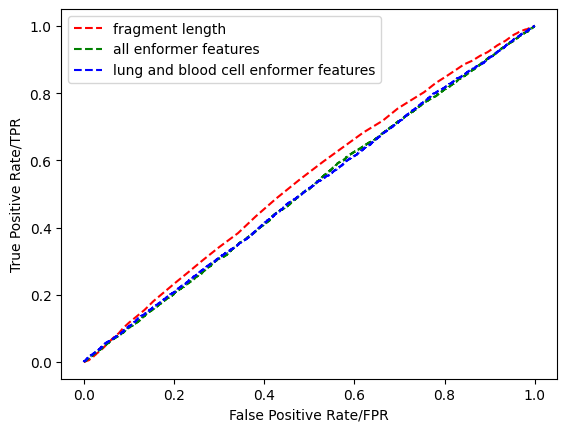

In [30]:
def makeRocAucPlot(y_pred_prob, y_test, y_pred_prob_all, y_test_all, y_pred_prob_length, y_test_length):
    auc_score = roc_auc_score(y_test, y_pred_prob)
    train_fpr, train_tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=1)

    auc_score_all = roc_auc_score(y_test_all, y_pred_prob_all)
    train_fpr_all, train_tpr_all, _ = roc_curve(y_test_all, y_pred_prob_all, pos_label=1)

    auc_score_length = roc_auc_score(y_test_length, y_pred_prob_length)
    train_fpr_length, train_tpr_length, _ = roc_curve(y_test_length, y_pred_prob_length, pos_label=1)

    print(f"auc: {auc_score} and all auc: {auc_score_all} and length auc : {auc_score_length}")
    #Get random predictions
    random_pred_val = [0 for i in range(len(y_test))]
    r_fpr, r_tpr, _ = roc_curve(y_test, random_pred_val, pos_label=1)

    plt.plot(train_fpr_length, train_tpr_length, linestyle='--',color='red', label='fragment length')
    plt.plot(train_fpr, train_tpr, linestyle='--',color='green', label='all enformer features')
    plt.plot(train_fpr_all, train_tpr_all, linestyle='--',color='blue', label='lung and blood cell enformer features')

    # plt.plot(r_fpr, r_tpr, linestyle='--', color='black', label = "random predictor")
    plt.xlabel('False Positive Rate/FPR')
    plt.ylabel('True Positive Rate/TPR')
    plt.legend(loc='best')
    plt.show()

makeRocAucPlot(y_pred_prob, y_test, y_pred_prob_all, y_test_all, y_pred_prob_length, y_test_length)

**make TNSE plot of all the features**

In [ ]:
tsne_plot_path = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/one_time_use_side_scripts/enformer_tracks_initial_analysis_plots/tsne_plot"
df_for_tsne = enformer_tracks_scaled_df.drop(['target', 'target_name'], axis = 1)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_for_tsne)
print("Finished getting TSNE results")

**Get TSNE results for high perplexity**

In [ ]:
tsne_plot_path = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/one_time_use_side_scripts/enformer_tracks_initial_analysis_plots/tsne_plot"
df_for_tsne = enformer_tracks_scaled_df.drop(['target', 'target_name'], axis = 1)
tsne_high_perplexity = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=300)
tsne_results_high_perplex = tsne_high_perplexity.fit_transform(df_for_tsne)
print("Finished getting TSNE results")

**Get TSNE results for low perplexity**

In [ ]:
tsne_plot_path = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/one_time_use_side_scripts/enformer_tracks_initial_analysis_plots/tsne_plot"
df_for_tsne = enformer_tracks_scaled_df.drop(['target', 'target_name'], axis = 1)
tsne_low_perplexity = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results_low_perplex = tsne_low_perplexity.fit_transform(df_for_tsne)
print("Finished getting TSNE results")

In [ ]:
print(f"Num donors: {num_donors} and num recipients: {num_recips}")

def getToPlotTsneDf(tsne_results):
    tsne_resuts_df = pd.DataFrame(tsne_results, columns = ["TSNE axis 1", "TSNE axis 2"])
    print(len(tsne_resuts_df))
    tsne_resuts_df.loc[0:num_donors-1, "target"] = 1
    tsne_resuts_df.loc[0:num_donors-1, "target_name"] = "donor"
    tsne_resuts_df.loc[num_donors:num_donors + num_recips - 1, "target"] = 0
    tsne_resuts_df.loc[num_donors:num_donors + num_recips -1, "target_name"] = "recipient"
    shuffled_df = tsne_resuts_df.sample(frac=1).reset_index(drop=True)

    return shuffled_df

to_plot_high_perplex = getToPlotTsneDf(tsne_results_high_perplex)
to_plot_low_perplex = getToPlotTsneDf(tsne_results_high_perplex)

fig = plt.subplots(figsize=(8, 6))

sns.jointplot(data=to_plot_low_perplex, x="TSNE axis 1", y='TSNE axis 2', hue="target_name")
# sns.jointplot(data=to_plot_low_perplex, x="TSNE axis 1", y='TSNE axis 2', hue="target_name")

# fig.subplots_adjust(hspace=0.75, wspace=0.75)

# ax1.title.set_text(f'Perplexity = 70')
# ax2.title.set_text(f'Perplexity = 10')

# # Add labels and legend
# plt.title("T-SNE Visualization of Enformer tracks (perplexity = 10)", y = 1.2)
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
plt.legend()

# Show the plot
plt.show()

**Make a UMAp plot of all the features**